In [23]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def merging():
    df=pd.DataFrame()
    dir_path1=os.listdir(os.path.join("data","GHI",))
    dir_path2=os.listdir(os.path.join("data","PR",))
    for dir1, dir2 in zip(dir_path1, dir_path2):
        for file1, file2 in zip(os.listdir(os.path.join("data","GHI",dir1)), os.listdir(os.path.join("data","PR",dir2))):
            if file1.endswith(".csv") and file2.endswith(".csv"):
                # on_column = "Date"
                df1 = pd.read_csv(os.path.join("data", "GHI", dir1, file1)) 
                df2 = pd.read_csv(os.path.join("data", "PR", dir2, file2))
                # print(f"Merging {file1} and {file2} on column '{on_column}'")
                print(f"{df1.shape} rows in {file1}, {df2.shape} rows in {file2}")
                merged_df = pd.merge(df1, df2, on="Date")
                df=pd.concat([df, merged_df], ignore_index=True)
    df.to_csv(os.path.join("data", "merged_data.csv"), index=False)
    print("Merging completed. Merged data saved to 'data/merged_data.csv'.")
                

In [ ]:
merging()

In [17]:
df=pd.read_csv(os.path.join("data", "merged_data.csv"))
df.head()

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    982 non-null    object 
 1   GHI     982 non-null    float64
 2   PR      982 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.1+ KB


<Axes: title={'center': 'GHI and PR over Time'}, xlabel='Date'>

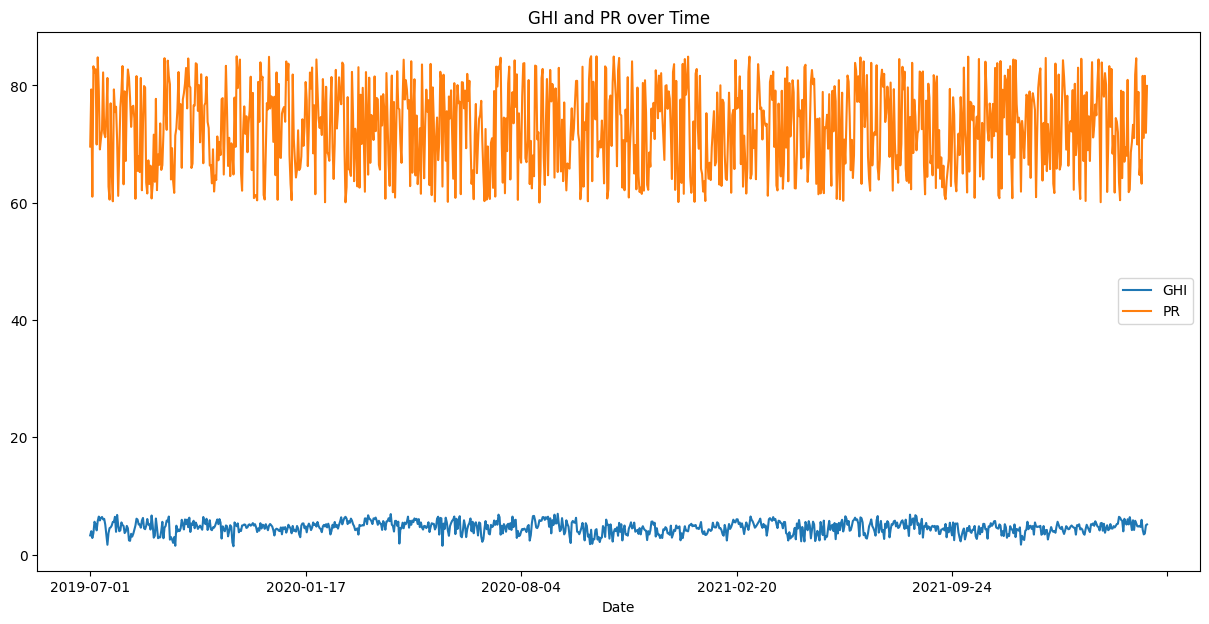

In [24]:
df.plot(x="Date", y=["GHI", "PR"], figsize=(15, 7), title="GHI and PR over Time")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

def visualize_pr(df, output_path="pr_graph.png"):
    """
    Given a DataFrame `df` with columns ['Date', 'GHI', 'PR'], this function:
      1. Ensures 'Date' is datetime and sorts by date.
      2. Computes a 30-day moving average of PR.
      3. Computes a yearly budget line (starting at 73.9 on July 1 2019,
         then decreasing by 0.8 each Jul 1 thereafter).
      4. Builds a scatter plot of daily PR, colored by GHI bins:
         • GHI < 2   → navy
         • 2 ≤ GHI < 4   → lightblue
         • 4 ≤ GHI < 6   → orange
         • GHI ≥ 6   → brown
      5. Overlays the 30-day MA (red) and budget line (dark green).
      6. Adds a legend for color bins, MA line, and budget line.
      7. Draws a text box (bottom right) showing average PR over the last
         7, 30, 60, 90, and 180 days.
      8. Saves the figure to `output_path` and shows it.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least these columns:
          - 'Date' (string or datetime)
          - 'GHI'  (float)
          - 'PR'   (float)
    output_path : str
        Path to save the final PNG (default: "pr_graph.png").

    Returns
    -------
    None
    """
    # 1) Ensure Date is datetime, sort, and reset index
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2) Compute 30-day rolling average of PR
    df['PR_30d_MA'] = df['PR'].rolling(window=30, min_periods=1).mean()

   
    def compute_budget_for_date(d):
        # Determine "budget‐year" index:
        # If month >= 7, period_year = year; else period_year = year - 1
        if d.month >= 7:
            period_year = d.year
        else:
            period_year = d.year - 1
        year_index = period_year - 2019
        return 73.9 - 0.8 * year_index

    df['Budget_PR'] = df['Date'].apply(compute_budget_for_date)

    # 4) Map GHI → colors
    def ghi_to_color(ghi):
        if ghi < 2:
            return 'navy'
        elif ghi < 4:
            return 'lightblue'
        elif ghi < 6:
            return 'orange'
        else:
            return 'brown'

    df['Color'] = df['GHI'].apply(ghi_to_color)

    # 5) Begin plotting
    plt.figure(figsize=(14, 7))
    ax = plt.gca()

    # (a) Scatter of daily PR, colored by GHI bin
    ax.scatter(
        df['Date'],
        df['PR'],
        c=df['Color'],
        s=20,
        alpha=0.8,
        label="Daily PR"
    )

    # (b) 30-day moving average (red line)
    ax.plot(
        df['Date'],
        df['PR_30d_MA'],
        color='red',
        linewidth=2,
        label="30-day MA of PR"
    )

    # (c) Budget line (dark green)
    ax.plot(
        df['Date'],
        df['Budget_PR'],
        color='darkgreen',
        linewidth=2,
        linestyle='--',
        label="Budget PR"
    )

    # 6) Build custom handles for scatter‐legend (one handle per GHI‐bin)
    patch_navy     = mpatches.Patch(color='navy',     label='GHI < 2')
    patch_lightblu = mpatches.Patch(color='lightblue', label='2 ≤ GHI < 4')
    patch_orange   = mpatches.Patch(color='orange',   label='4 ≤ GHI < 6')
    patch_brown    = mpatches.Patch(color='brown',    label='GHI ≥ 6')
    line_ma_red    = mpatches.Patch(color='red',       label='30-day MA (PR)')
    line_budget    = mpatches.Patch(color='darkgreen', label='Budget PR')

    # Add legend (use one entry per color/bin + lines)
    legend_handles = [
        patch_navy,
        patch_lightblu,
        patch_orange,
        patch_brown,
        line_ma_red,
        line_budget
    ]
    ax.legend(
        handles=legend_handles,
        loc='upper left',
        frameon=True,
        fontsize=9
    )

    # 7) Summary box (bottom right) with average PR over last X days.
    last_date = df['Date'].max()

    def avg_pr_over_last_n(n):
        cutoff = last_date - pd.Timedelta(days=n - 1)
        subset = df[df['Date'] >= cutoff]
        if len(subset) == 0:
            return float('nan')
        return subset['PR'].mean()

    avg7   = avg_pr_over_last_n(7)
    avg30  = avg_pr_over_last_n(30)
    avg60  = avg_pr_over_last_n(60)
    avg90  = avg_pr_over_last_n(90)
    avg180 = avg_pr_over_last_n(180)

    summary_text = (
        f"Avg PR (last 7 d):  {avg7:.2f}\n"
        f"Avg PR (last 30 d): {avg30:.2f}\n"
        f"Avg PR (last 60 d): {avg60:.2f}\n"
        f"Avg PR (last 90 d): {avg90:.2f}\n"
        f"Avg PR (last 180 d):{avg180:.2f}"
    )

    ax.text(
        0.98, 0.15,
        summary_text,
        transform=ax.transAxes,
        fontsize=9,
        ha='right',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.9)
    )

    # 8) Formatting
    ax.set_title("Daily PR vs. Date (colored by GHI)", fontsize=14, pad=15)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("PR (%)", fontsize=12)

    # Format x-axis for readability
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()


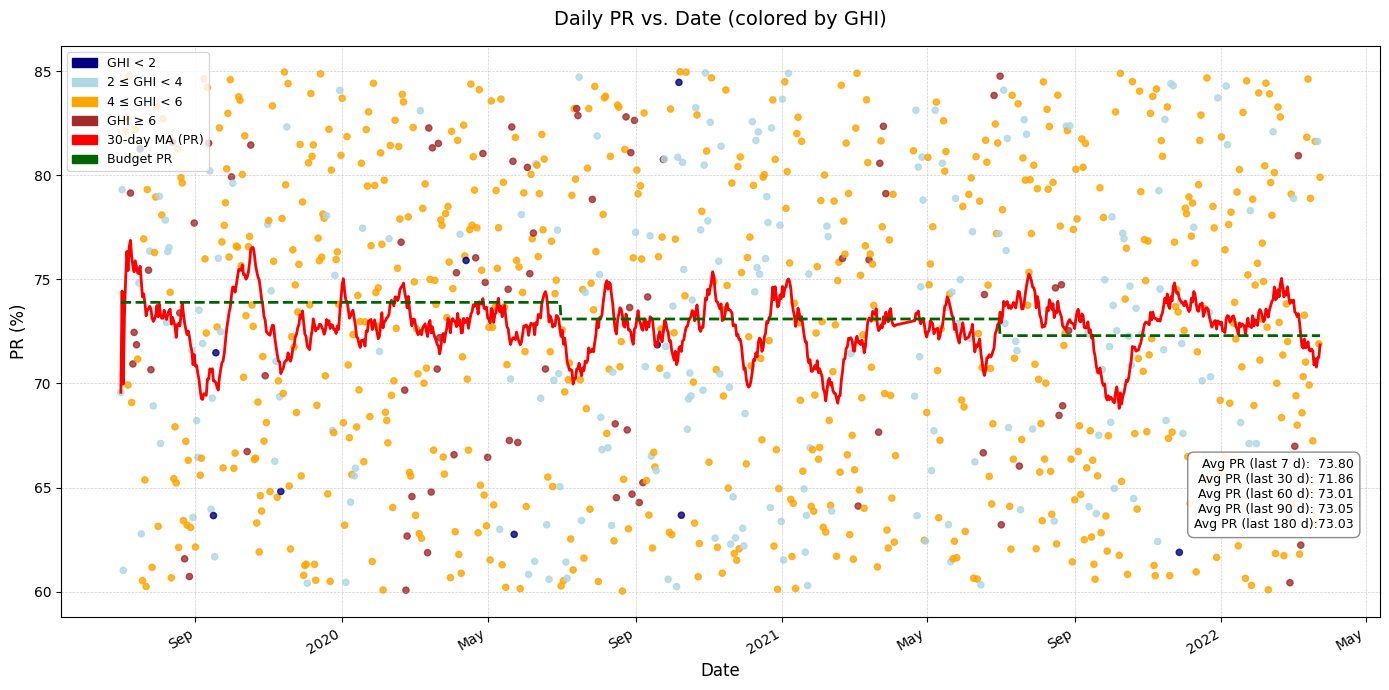

In [26]:
visualize_pr(df)